# Behavioral Modeling of a BSS123 MOSFET with Machine Learning

## Introduction:
This notebook attempts to create a machine learning model to predict the I-V characteristics of a BSS123 N-Channel MOSFET. The goal is to build a behavioral model that approximates the device's drain current ($I_{DS}$), using the gate-source voltage ($V_{GS}$) and drain-source voltage ($V_{DS}$) as input parameters.

## Workflow:
1. Modeling the device in LTSpice.
2. Exporting the raw data as text.
3. Parsing the raw simulation data, cleaning and then turning it into a usable pandas data frame.
4. Exploring the data obtained and visualizing the MOSFET's characteristic curves
5. Training and evaluating the data using various regression models
6. Analysing the result and attempting to derive an explicit equation from the model.

## LTspice Measurement Setup
![LTspice schematic showing measurement setup](images/MOSFET_BSS123.png "Figure: Circuit used to collect MOSFET data")

**Figure:** LTSpice schematic of the circuit used to generate the dataset. Editable sources are available in `../sim/mosfet.asc` (schematic) and `../sim/mosfet.net` (netlist); the captured sweep is stored in `data/mosfet_BSS123.txt`.

## 1. Parsing Data from LTSpice Output
- The raw text file is generated with LTSpice DC Sweep functionality. This file is semi-structured and not suitable to work with a model.
- The re library is thus used to parse through the data, identify step values of $V_{GS}$, then extract the corresponding $V_{DS}$ and $I_{DS}$ data from the table.
- The data is then compiled and stored in a CSV file for future use (if required)

In [ ]:
import re
import pandas as pd

file_path = r'data/mosfet_BSS123.txt'

v_gs, v_ds, i_ds = [], [], []
current_vgs = None

with open(file_path, 'r') as file:
    for line in file:
        if 'Step Information: V_GS=' in line:
            match = re.search(r'V_GS=([0-9\.\-]+[munpkMG]?)', line)     #Searches for the phrase "V_GS={number}{unit}" in each line of file
            if match.group(1)[-1] in 'munpkMG':     #The following code lines add the necessary powers of the value if it contains units instead
                current_vgs = float(match.group(1)[0:-1])
                suffix = match.group(1)[-1]
                
                if suffix == 'm':
                    current_vgs *= 1e-3
                elif suffix == 'u':
                    current_vgs *= 1e-6
                elif suffix == 'n':
                    current_vgs *= 1e-9
                elif suffix == 'p':
                    current_vgs *= 1e-12
                elif suffix == 'k':
                    current_vgs *= 1e3
                elif suffix == 'M':
                    current_vgs *= 1e6
                elif suffix == 'G':
                    current_vgs *= 1e9
            else:
                current_vgs = float(match.group(1))
        
        elif ('\t' in line) and (current_vgs != None):
            try:
                str_vds, str_ids = line.strip().split(sep='\t')
            
                v_ds.append(float(str_vds))
                i_ds.append(float(str_ids))
                v_gs.append(current_vgs)
            except ValueError:
                continue

data = {'V_GS': v_gs, 'V_DS': v_ds, 'I_DS': i_ds}
df = pd.DataFrame(data)

print(df.head(300))

df.to_csv(r'data/mosfet_data.csv', index=False)

     V_GS  V_DS          I_DS
0     0.0  0.00  6.499139e-11
1     0.0  0.05  2.444916e-12
2     0.0  0.10  2.834930e-12
3     0.0  0.15  2.930765e-12
4     0.0  0.20  2.991920e-12
..    ...   ...           ...
295   0.5  4.70  8.894489e-12
296   0.5  4.75  8.944523e-12
297   0.5  4.80  8.994558e-12
298   0.5  4.85  9.044591e-12
299   0.5  4.90  9.094625e-12

[300 rows x 3 columns]


## 2. Exploratory Data Analysis (EDA) & Visualization
Before moving on to training, the data is validated. By plotting the I-V curves, it is made sure that the data was parsed correctly and accurately represents the triode and saturation regions.

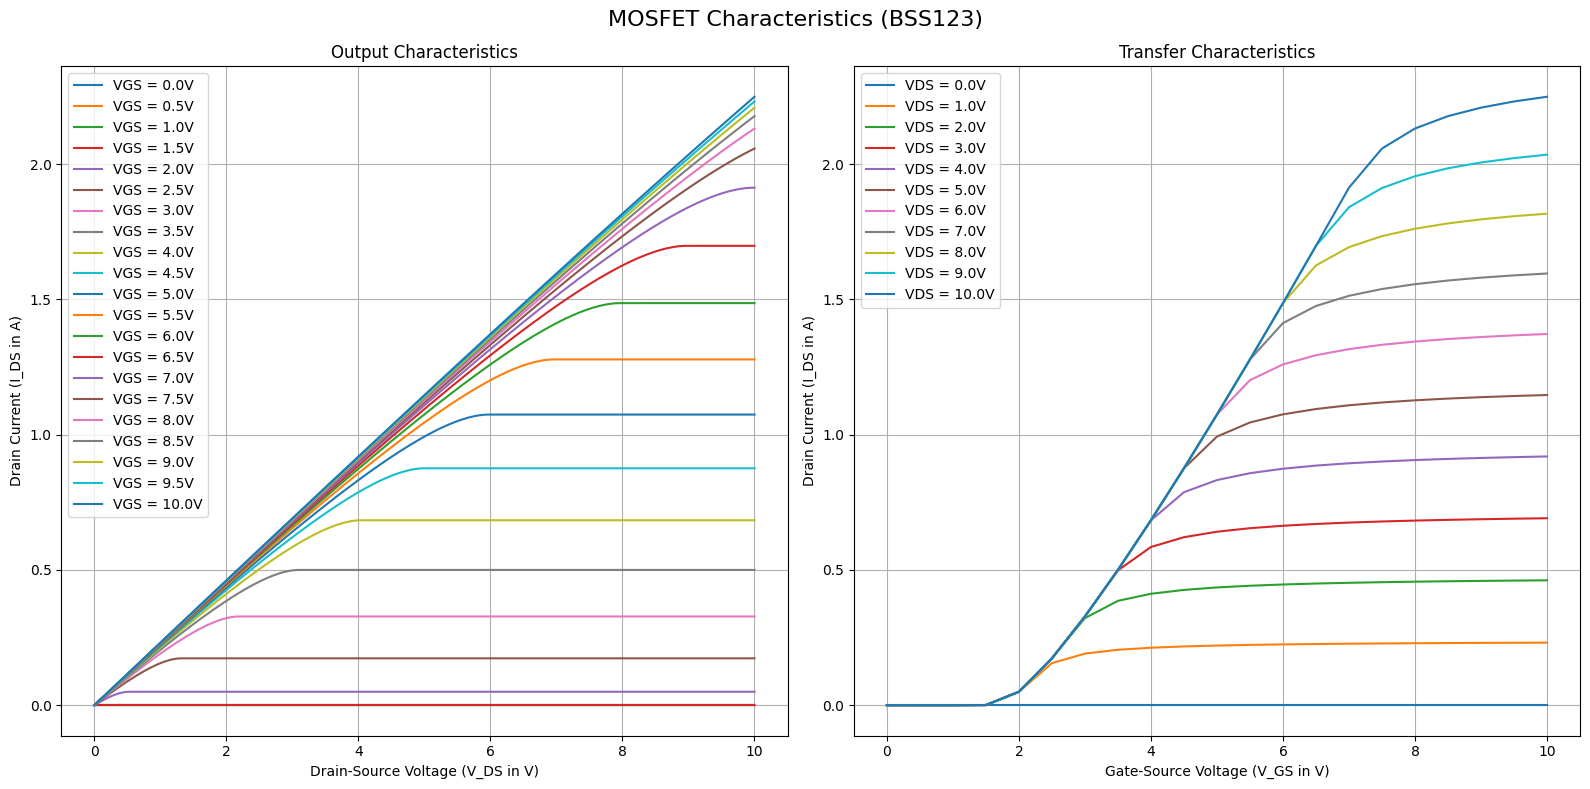

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv(r'data/mosfet_data.csv')

# Create figure with two subplots
plt.figure(figsize=(16, 8))

# 1. Output characteristics: I_DS vs V_DS for different V_GS values
plt.subplot(1, 2, 1)
unique_vgs = sorted(df['V_GS'].unique())
for vgs in unique_vgs:
    subset = df[df['V_GS'] == vgs]
    plt.plot(subset['V_DS'], subset['I_DS'], label=f'VGS = {vgs}V')

plt.xlabel('Drain-Source Voltage (V_DS in V)')
plt.ylabel('Drain Current (I_DS in A)')
plt.title('Output Characteristics')
plt.grid(True)
plt.legend()

# 2. Transfer characteristics: I_DS vs V_GS for selected V_DS values
plt.subplot(1, 2, 2)
unique_vds = sorted(df['V_DS'].unique())
# Select a few representative V_DS values to avoid overcrowding
selected_vds = unique_vds[::20]
for vds in selected_vds:
    subset = df[df['V_DS'].round(2) == round(vds, 2)]
    plt.plot(subset['V_GS'], subset['I_DS'], label=f'VDS = {vds:.1f}V')

plt.xlabel('Gate-Source Voltage (V_GS in V)')
plt.ylabel('Drain Current (I_DS in A)')
plt.title('Transfer Characteristics')
plt.grid(True)
plt.legend()

plt.suptitle('MOSFET Characteristics (BSS123)', fontsize=16)
plt.tight_layout()
plt.show()

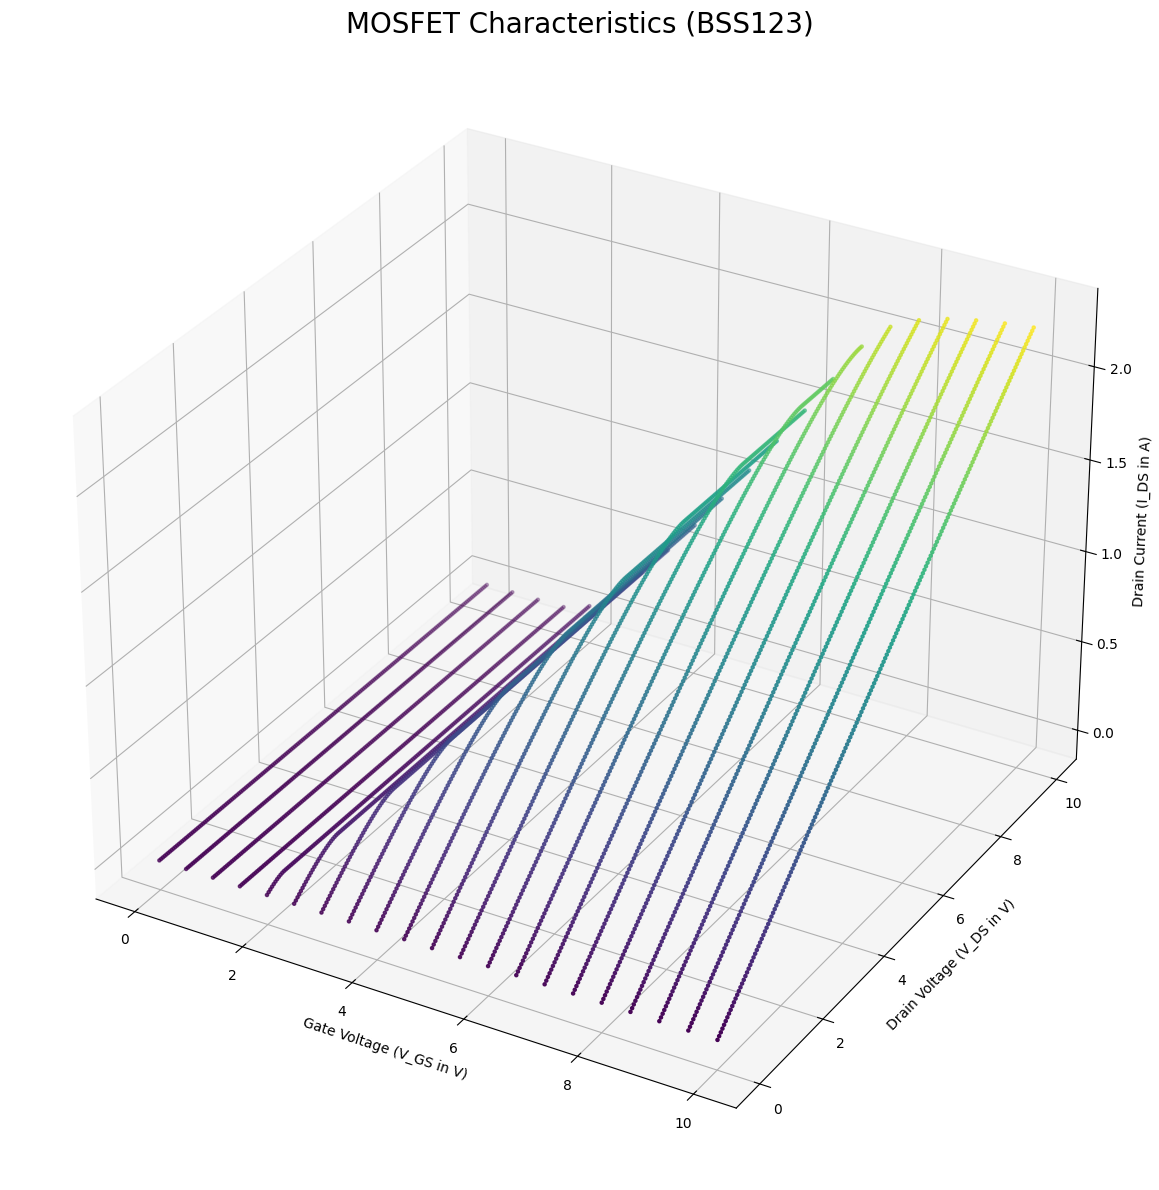

In [145]:
#3D plot showing Dependence of I_DS on both V_GS and V_DS
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['V_GS'], df['V_DS'], df['I_DS'], cmap='viridis', c=df['I_DS'], marker='.')
ax.set_xlabel('Gate Voltage (V_GS in V)')
ax.set_ylabel('Drain Voltage (V_DS in V)')
ax.set_zlabel('Drain Current (I_DS in A)')
ax.set_title('MOSFET Characteristics (BSS123)',fontsize=20)

plt.tight_layout()
plt.show()

## 3. Data Splitting and Scaling
- The model is split into a 75% training set and 25% test set.
- The Input Features ($V_{GS}$ and $V_{DS}$) are standardized using 'StandardScaler' to ensure both features contribute equally to the model's training process.

In [146]:
#Splitting data for Training and Testing (75:25)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[['V_GS', 'V_DS']]
y = df['I_DS']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42, shuffle=True)   #Fixed random state to reproduce results

print(f'Shape of X_train : {X_train.shape}\tShape of X_test : {X_test.shape}')
print(f'Shape of y_train : {y_train.shape}\tShape of y_test : {y_test.shape}')

#Scaling Data to fit input between 0-1

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Shape of X_train : (3165, 2)	Shape of X_test : (1056, 2)
Shape of y_train : (3165,)	Shape of y_test : (1056,)


## 4. The Machine Learning Models used: 

### 4.1 The Linear Regression Model

- While the Linear Model may not serve to be of much use in this analysis, it is helpful in proving that the relation between the input and output parameters is indeed non-linear, as seen by the low $R^2$ Score.
- In fact, the $R^2$ Score obtained serves as a baseline score to prove that other non-linear models do have improved predictions.

R2 Score: 0.7711
Mean Squared Error (RMSE): 0.0905
Root Mean Squared Error (RMSE): 0.3009


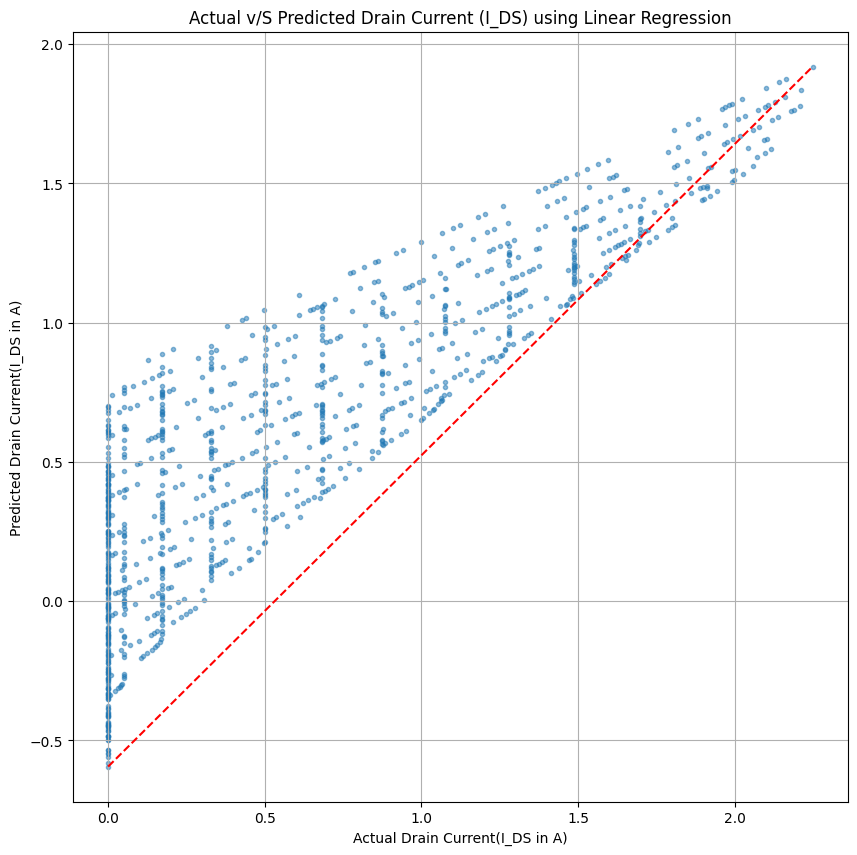

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
y_pred_linear = linear_model.predict(X_test_scaled)

r2_linear = r2_score(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)

print(f'R2 Score: {r2_linear:.4f}')
print(f'Mean Squared Error (MSE): {mse_linear:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_linear:.4f}')

#Plotting Actual v/s Predicted Plot with a 45 degree line to show perfect prediction

plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred_linear, alpha=0.5, marker='.')
plt.plot([y_test.min(), y_test.max()], [y_pred_linear.min(), y_pred_linear.max()], 'r--')
plt.xlabel('Actual Drain Current(I_DS in A)')
plt.ylabel('Predicted Drain Current(I_DS in A)')
plt.title('Actual v/S Predicted Drain Current (I_DS) using Linear Regression')
plt.grid(True)
plt.show()

### 4.2. The Polynomial Regression Model (Degree = 2)
- Coming from the linear model, the polynomial model is used to train the data. The purpose is to find out if a rather simple, interpretable equation can capture the device's non-linear behavior. 
- This model allows us to extract the equation used, to examine the relationship between the features.
- The respectable $R^2$ Score shows the feasibility of the model.

Shape of polynomial features: (3165, 5)
R2 Score: 0.9567
Mean Squared Error (RMSE): 0.0171
Root Mean Squared Error (RMSE): 0.1308


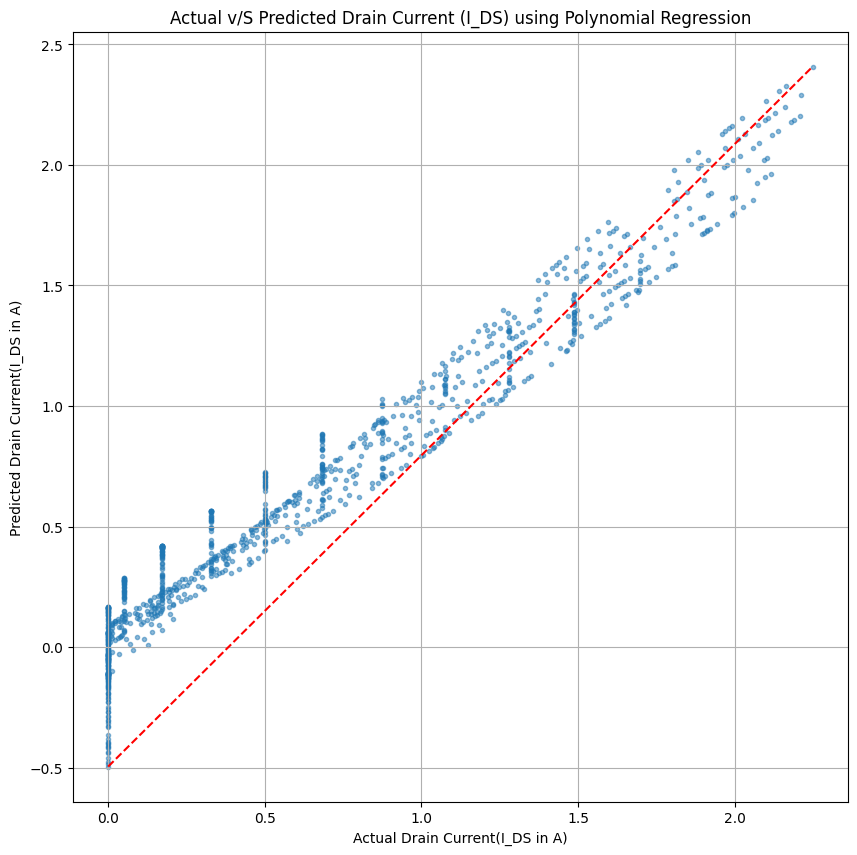

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print(f'Shape of polynomial features: {X_train_poly.shape}')

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

y_pred_poly = poly_model.predict(X_test_poly)

r2_poly = r2_score(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)

print(f'R2 Score: {r2_poly:.4f}')
print(f'Mean Squared Error (MSE): {mse_poly:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse_poly:.4f}')

plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred_poly, alpha=0.5, marker='.')
plt.plot([y_test.min(), y_test.max()], [y_pred_poly.min(), y_pred_poly.max()], 'r--')
plt.xlabel('Actual Drain Current(I_DS in A)')
plt.ylabel('Predicted Drain Current(I_DS in A)')
plt.title('Actual v/S Predicted Drain Current (I_DS) using Polynomial Regression')
plt.grid(True)
plt.show()


In [149]:
#Extracting the equation from the model

feature_names = poly.get_feature_names_out(['V_GS', 'V_DS'])
coefficients = poly_model.coef_

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficients': coefficients})
print(f'Coefficients and Features used : {coef_df.head(10)}')

intercept = poly_model.intercept_
print(f"\nIntercept: {intercept}")

equation = f"I_DS = {intercept:.6e}"
for feat, coef in zip(feature_names, coefficients):
    if abs(coef) > 1e-10:
        equation += f' + ({coef:.6e} * {feat})'
print(f'\n===Full equation===\n{equation}')

Coefficients and Features used :      Feature  Coefficients
0       V_GS      0.433956
1       V_DS      0.319319
2     V_GS^2     -0.086840
3  V_GS V_DS      0.258232
4     V_DS^2     -0.049683

Intercept: 0.797120546931029

===Full equation===
I_DS = 7.971205e-01 + (4.339565e-01 * V_GS) + (3.193190e-01 * V_DS) + (-8.684028e-02 * V_GS^2) + (2.582322e-01 * V_GS V_DS) + (-4.968271e-02 * V_DS^2)


### 4.3. The Random Forest Regression Model
- An ensemble model known for its high performance and ability to capture complex interactions without any explicit feature-engineering. 
- It is a highly accurate model based on Decision Tree, thus extracting an equation from this model is impossible.
- The perfect $R^2$ Score shows this to be the best performer.

R2 Score: 1.0000
Mean Squared Error (RMSE): 0.000012
Root Mean Squared Error (RMSE): 0.0035


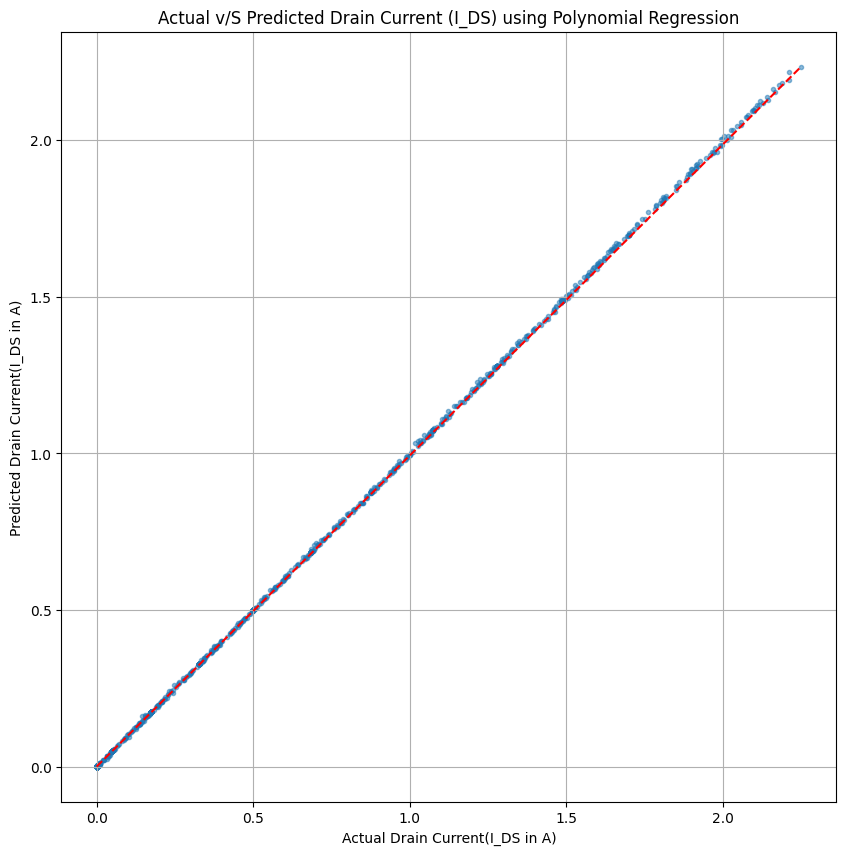

In [ ]:

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)

r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print(f'R2 Score: {r2_rf:.4f}')
print(f'Mean Squared Error (MSE): {mse_rf:.6f}')
print(f'Root Mean Squared Error (RMSE): {rmse_rf:.4f}')

plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred_rf, alpha=0.5, marker='.')
plt.plot([y_test.min(), y_test.max()], [y_pred_rf.min(), y_pred_rf.max()], 'r--')
plt.xlabel('Actual Drain Current(I_DS in A)')
plt.ylabel('Predicted Drain Current(I_DS in A)')
plt.title('Actual v/S Predicted Drain Current (I_DS) using Random Forest Regression')
plt.grid(True)
plt.show()

## 5. Conclusion and Analysis

### 5.1 Model Performance Comparison

| Model | R² Score | MSE | RMSE | Interpretability | Computational Complexity |
|-------|----------|-----|------|-----------------|--------------------------|
| Linear Regression | 0.7711 | 0.0905 | 0.3008 | High | Low |
| Polynomial Regression (degree=2) | 0.9567 | 0.0171 | 0.1308 | Medium | Medium |
| Random Forest | 1.0000 | 0.000012 | 0.0035 | Low | High |

### 5.2 Derived Mathematical Model

The polynomial regression model yielded an explicit mathematical formula that captures the MOSFET behavior:

$$I_{DS} = 0.797 + 0.434 V_{GS} + 0.319 V_{DS} - 0.087 V_{GS}^2 + 0.258 V_{GS}V_{DS} - 0.050 V_{DS}^2$$

This equation demonstrates several key aspects of MOSFET behavior:

1. **Linear dependency**: The positive coefficients for $V_{GS}$ and $V_{DS}$ terms show the basic direct relationship between voltages and drain current.
   
2. **Saturation effects**: The negative quadratic terms ($V_{GS}^2$ and $V_{DS}^2$) capture the saturation behavior where current increases less rapidly at higher voltages.

3. **Gate-Drain interaction**: The positive cross-term ($V_{GS} \cdot V_{DS}$) represents how gate voltage modulates the effect of drain voltage, which is fundamental to MOSFET operation.

### 5.3 Analysis Summary

This project successfully created a behavioral model of the BSS123 N-Channel MOSFET using machine learning techniques. While the Random Forest model achieved the highest accuracy with an R² score close to perfect, the polynomial regression model provides a valuable balance between accuracy and interpretability.

The derived equation from polynomial regression closely resembles the theoretical square-law MOSFET model, validating both our approach and the underlying device physics. This demonstrates that relatively simple mathematical models can effectively capture complex semiconductor behavior when properly constructed.

### 5.4 Applications and Future Work

The developed models have several practical applications:

- **Fast circuit simulation**: The polynomial equation can be implemented in circuit simulators, for the given MOSFET, for faster computation compared to complex SPICE models.
- **Educational tool**: A useful project when studying both Devices and Machine Learning to gain better understanding.

Potential extensions of this work include:
- Incorporating temperature effects and other parameters
- Extending the model to other MOSFET types and transistor families
- Adding dynamic behavior modeling (capacitive effects)
- Creating a general framework for behavioral modeling of other semiconductor devices